In [1]:
import tensorflow as tf
from keras import layers as L
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import numpy as np
import gc
from utils.utils import load_n_samples, AEDatagenerator
sns.set()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


# Some major settings

In [2]:
training = True

In [3]:
name_dec = 'models/dec.h5'
name_enc = 'models/enc.h5'

# Loading data

In [4]:
abs_path = 'data/cropped/'
files = os.listdir(abs_path)
files = list(map(lambda x: os.path.join(abs_path, x), files))

In [5]:
train_path, test_path = train_test_split(files,test_size=0.15)

In [6]:
len(train_path), len(test_path)

(54032, 9536)

In [7]:
data = load_n_samples(abs_path=abs_path,samples=1000,workers=2)

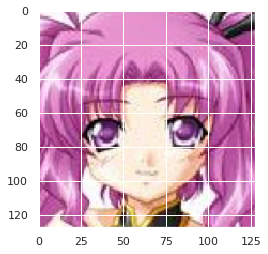

In [8]:
plt.imshow(data[0]);

# Training VAE

In [9]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [46]:
def build_model(original_dim, code_size, batch_size=32, std=0.1,print_summary=True):
    x = L.Input(batch_shape=(batch_size, *original_dim))
    encoder = create_encoder(original_dim,code_size)
    get_t_mean = L.Lambda(lambda h: h[:, :code_size])
    get_t_log_var = L.Lambda(lambda h: h[:, code_size:])
    h = encoder(x)
    t_mean = get_t_mean(h)
    t_log_var = get_t_log_var(h)
    t = L.Lambda(sample)([t_mean,t_log_var])
    decoder = create_decoder(code_size)
    x_encoded_mean = decoder(t)
    vae = keras.Model(x,x_encoded_mean)
    loss = vlb_multinomial(x, x_encoded_mean,std,t_log_var,t_mean)
    vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x,y : loss)
    if print_summary:
        print(vae.summary())
    return vae,decoder, encoder

def vlb_multinomial(x, x_encoded_mean,std,t_log_var,t_mean):
    loss =  gaussian_loss(x, x_encoded_mean,std)
    reg = kl_divergence(t_log_var,t_mean)
    return tf.reduce_mean(loss+reg) 

def gaussian_loss(x,x_encoded_mean,std):
    x = tf.reshape(x,shape=(tf.shape(x)[0],-1))
    x_encoded_mean = tf.reshape(x_encoded_mean,shape=(tf.shape(x_encoded_mean)[0],-1))
    return 0.5 * tf.reduce_sum(tf.square(x - x_encoded_mean),axis=1) / (2*tf.square(std)) + tf.log(std)

def kl_divergence(t_log_var,t_mean):
    return 0.5*tf.reduce_sum(-t_log_var+tf.exp(t_log_var)+tf.square(t_mean)-1,1)

def sample(args):
    t_mean, t_log_var = args
    shape = tf.shape(t_mean)
    eps = tf.random.normal(
    shape=shape)
    return t_mean+eps*tf.exp(0.5*t_log_var)

def create_encoder(input_shape,code_size):
        encoder = keras.models.Sequential(name='encoder')
        encoder.add(L.InputLayer(input_shape))
        encoder.add(L.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Flatten())
        encoder.add(L.Dense(units=2*code_size,activation='elu'))
        print(encoder)
        return encoder 

def create_decoder(code_size):
        decoder = keras.models.Sequential(name='decoder')
        decoder.add(L.InputLayer((code_size,)))
        decoder.add(L.Dense(2*2*512,activation='elu'))
        decoder.add(L.Reshape(target_shape=(2,2,512)))
        decoder.add(L.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation = 'relu', strides=2, padding='same'))
        print(decoder.summary())
        return decoder


In [47]:
batch_size = 128
original_dim = (128,128,3)
code_size = 3
epochs = 10
std = 0.1

In [48]:
vae,decoder, encoder = build_model(original_dim,code_size,batch_size,std)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 2048)              8192      
_________________________________________________________________
reshape_8 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_43 (Conv2DT (None, 4, 4, 512)         2359808   
_________________________________________________________________
conv2d_transpose_44 (Conv2DT (None, 8, 8, 256)         1179904   
_________________________________________________________________
conv2d_transpose_45 (Conv2DT (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_46 (Conv2DT (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_transpose_47 (Conv2DT (None, 64, 64, 32)        1846

In [49]:
train_gen = AEDatagenerator(pathes=train_path,batch_size=batch_size,
                        dim=original_dim[:2],
                        n_channels=original_dim[2])
test_gen = AEDatagenerator(pathes=test_path,batch_size=batch_size,
                        dim=original_dim[:2],
                        n_channels=original_dim[2])
hist = vae.fit_generator(generator=train_gen,validation_data=test_gen,epochs=epochs)

Epoch 1/10
  6/422 [..............................] - ETA: 3:52 - loss: 13551474.8177

KeyboardInterrupt: 

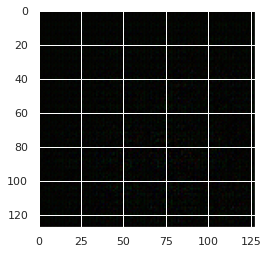

In [52]:
plt.imshow(decoder.predict(sess.run(tf.random.normal(shape=(1,3))))[0])